# Capstone Two - 5 Extended Modeling<a id='5'></a>

## 5.1 Contents<a id='5.1'></a>
* [5 Extended Modeling](#5)
  * [5.1 Contents](#5.1)
  * [5.2 Imports](#5.2)
  * [5.3 Load The Data](#5.3)
  * [5.4 Data Processing](#5.4)
  * [5.5 Modeling](#5.5)
    * [5.5.1 Apply auto_arima() for single timeseries](#5.5.1)
    * [5.5.2 Apply auto_arima() for multiple timeseries](#5.5.2)
    * [5.5.3 Apply Prophet() for single timeseries](#5.5.3)
    

## 5.2 Imports<a id='5.2'></a>

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [2]:
import pmdarima as pm
from pmdarima.model_selection import train_test_split

from prophet import Prophet

## 5.3 Load The Data<a id='5.3'></a>

In [3]:
data_dir = '../data/'

data_ori = pd.read_csv(data_dir+'train_all_groups.csv')
data_ori.head(3)

,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,dcoilwtico,transactions,holiday_type,transferred,year,month
0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,93.14,0.0,Holiday,False,2013,1
1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,93.14,0.0,Holiday,False,2013,1
2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,93.14,0.0,Holiday,False,2013,1


In [4]:
data = data_ori[['date', 'store_nbr', 'family', 'sales']]
data.set_index('date', inplace = True)
data.head(3)

,store_nbr,family,sales
date,,,
2013-01-01,1,AUTOMOTIVE,0.0
2013-01-01,1,BABY CARE,0.0
2013-01-01,1,BEAUTY,0.0


## 5.4 Data Processing<a id='5.4'></a>

In [5]:
stores = data['store_nbr'].unique()
families = data['family'].unique()

print(stores)
print(families)
print(len(stores), len(families))

[ 1 10 11 12 13 14 15 16 17 18 19  2 20 21 22 23 24 25 26 27 28 29  3 30
 31 32 33 34 35 36 37 38 39  4 40 41 42 43 44 45 46 47 48 49  5 50 51 52
 53 54  6  7  8  9]
['AUTOMOTIVE' 'BABY CARE' 'BEAUTY' 'BEVERAGES' 'BOOKS' 'BREAD/BAKERY'
 'CELEBRATION' 'CLEANING' 'DAIRY' 'DELI' 'EGGS' 'FROZEN FOODS' 'GROCERY I'
 'GROCERY II' 'HARDWARE' 'HOME AND KITCHEN I' 'HOME AND KITCHEN II'
 'HOME APPLIANCES' 'HOME CARE' 'LADIESWEAR' 'LAWN AND GARDEN' 'LINGERIE'
 'LIQUOR,WINE,BEER' 'MAGAZINES' 'MEATS' 'PERSONAL CARE' 'PET SUPPLIES'
 'PLAYERS AND ELECTRONICS' 'POULTRY' 'PREPARED FOODS' 'PRODUCE'
 'SCHOOL AND OFFICE SUPPLIES' 'SEAFOOD']
54 33


In [6]:
grp = data.groupby(['store_nbr', 'family'])

df = pd.DataFrame()

for s in stores:
    for f in families:
        grp_sel = grp.get_group((s, f))
        col_name = str(s)+","+f
        df_temp = pd.DataFrame(grp_sel['sales']).rename(columns={'sales': col_name})
        df = pd.concat([df, df_temp], axis=1)

df.head()

,"1,AUTOMOTIVE","1,BABY CARE","1,BEAUTY","1,BEVERAGES","1,BOOKS","1,BREAD/BAKERY","1,CELEBRATION","1,CLEANING","1,DAIRY","1,DELI",...,"9,MAGAZINES","9,MEATS","9,PERSONAL CARE","9,PET SUPPLIES","9,PLAYERS AND ELECTRONICS","9,POULTRY","9,PREPARED FOODS","9,PRODUCE","9,SCHOOL AND OFFICE SUPPLIES","9,SEAFOOD"
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.000,...,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.000
2013-01-02,2.0,0.0,2.0,1091.0,0.0,470.652,0.0,1060.0,579.0,164.069,...,0.0,374.531,482.0,0.0,0.0,651.292,83.0,0.0,0.0,29.214
2013-01-03,3.0,0.0,0.0,919.0,0.0,310.655,0.0,836.0,453.0,151.582,...,0.0,400.863,372.0,0.0,0.0,509.496,66.0,0.0,0.0,25.000
2013-01-04,3.0,0.0,3.0,953.0,0.0,198.366,0.0,827.0,460.0,131.411,...,0.0,310.878,324.0,0.0,0.0,332.672,57.0,0.0,0.0,11.000
2013-01-05,5.0,0.0,3.0,1160.0,0.0,301.057,0.0,811.0,464.0,118.613,...,0.0,447.685,461.0,0.0,0.0,510.919,84.0,0.0,0.0,28.361


In [7]:
# train-test split: the last 16 days as testing set
n_train = len(df)-16
df_train = df[7:n_train] #starting from day 8
df_test = df[n_train:]

## 5.5 Modeling<a id='5.5'></a>

### 5.5.1 Apply auto_arima() for single timeseries<a id='5.5.1'></a>

In [8]:
y1_train = df_train["1,AUTOMOTIVE"] # first column
y1_test = df_test["1,AUTOMOTIVE"]

In [9]:
# use pmdarima to automatically select best ARIMA model
model = pm.auto_arima(y1_train,                    
                      start_p=0, start_q=0, # minimum p and q
                      max_p=7, max_q=7,     # maximum p and q
                      max_order=None,
                      test='adf',           # use adftest to find optimal 'd'
                      seasonal=True,
                      m=7,                   # seasonality: weekly
                      d=None,               # let model determine 'd' (order of first-differencing)
                      D=None,               # let model determine 'D' (order of the seasonal differencing)
                      trace=True,           # print status on the fits
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

# print model summary
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=7891.125, Time=1.37 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=8089.233, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=8038.275, Time=0.53 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=8048.556, Time=0.36 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=9526.536, Time=0.02 sec
 ARIMA(0,0,0)(0,0,1)[7] intercept   : AIC=8059.133, Time=0.17 sec
 ARIMA(0,0,0)(1,0,0)[7] intercept   : AIC=8047.737, Time=0.30 sec
 ARIMA(0,0,0)(2,0,1)[7] intercept   : AIC=7898.131, Time=2.99 sec
 ARIMA(0,0,0)(1,0,2)[7] intercept   : AIC=7891.691, Time=3.22 sec
 ARIMA(0,0,0)(0,0,2)[7] intercept   : AIC=8018.471, Time=0.45 sec
 ARIMA(0,0,0)(2,0,0)[7] intercept   : AIC=7992.324, Time=0.64 sec
 ARIMA(0,0,0)(2,0,2)[7] intercept   : AIC=7895.121, Time=2.92 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=7892.120, Time=1.82 sec
 ARIMA(0,0,1)(1,0,1)[7] intercept   : AIC=7892.113, Time=1.90 sec
 ARIMA(1,0,1)(1,0,1)[7] intercept

In [19]:
model

ARIMA(order=(0, 0, 0), scoring_args={}, seasonal_order=(1, 0, 1, 7),
      suppress_warnings=True)

In [20]:
# make forecasts
y1_pred = model.predict(y1_test.shape[0])  # predict N steps into the future

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [29]:
# APE = ABS((actual - predicted) / actual)
APE_y1 = abs( (y1_test.values - y1_pred.values) / y1_test.values) # ma: moving average model

# MEAN(APE)
mAPE_y1 = np.mean(APE_y1)
print('MAPE: '+str(mAPE_y1))

MAPE: 0.768867594013641


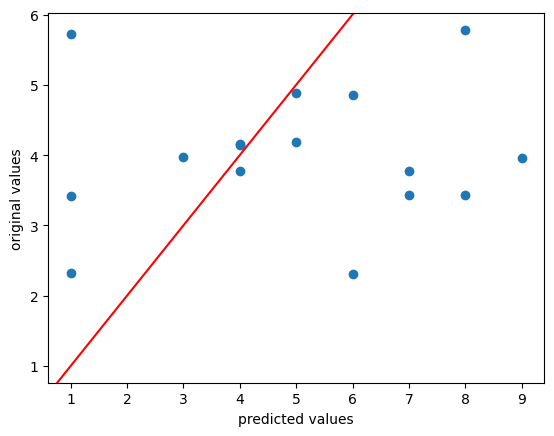

In [22]:
# predicted-vs-actual scatterplot
fig, ax = plt.subplots()
ax.scatter(y1_test.values, y1_pred.values)
plt.xlabel("predicted values")
plt.ylabel("original values")
ax.axline((1,1), slope=1, color = 'red')
plt.show()

### 5.5.2 Apply auto_arima() for multiple timeseries<a id='5.5.2'></a>

In [33]:
N = 10
mAPE = []
for group in df.columns[0:N]:
    y_train = df_train[group]
    y_test = df_test[group]
    
    model = pm.auto_arima(y_train,                    
                      start_p=0, start_q=0, # minimum p and q
                      max_p=7, max_q=7,     # maximum p and q
                      max_order=None,
                      test='adf',           # use adftest to find optimal 'd'
                      seasonal=True,
                      m=7,                   # seasonality: weekly
                      d=None,               # let model determine 'd' (order of first-differencing)
                      D=None,               # let model determine 'D' (order of the seasonal differencing)
                      trace=True,           # print status on the fits
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
    
    y_pred = model.predict(y_test.shape[0])
    
    APE_y = abs( (y_test.values - y_pred.values) / y_test.values)
    mAPE_y = np.mean(APE_y)
    print(group+' MAPE: '+str(mAPE_y))
    
    mAPE.append(mAPE_y)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=7891.125, Time=1.35 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=8089.233, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=8038.275, Time=0.52 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=8048.556, Time=0.36 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=9526.536, Time=0.02 sec
 ARIMA(0,0,0)(0,0,1)[7] intercept   : AIC=8059.133, Time=0.17 sec
 ARIMA(0,0,0)(1,0,0)[7] intercept   : AIC=8047.737, Time=0.29 sec
 ARIMA(0,0,0)(2,0,1)[7] intercept   : AIC=7898.131, Time=2.91 sec
 ARIMA(0,0,0)(1,0,2)[7] intercept   : AIC=7891.691, Time=3.17 sec
 ARIMA(0,0,0)(0,0,2)[7] intercept   : AIC=8018.471, Time=0.45 sec
 ARIMA(0,0,0)(2,0,0)[7] intercept   : AIC=7992.324, Time=0.63 sec
 ARIMA(0,0,0)(2,0,2)[7] intercept   : AIC=7895.121, Time=2.93 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=7892.120, Time=1.78 sec
 ARIMA(0,0,1)(1,0,1)[7] intercept   : AIC=7892.113, Time=1.86 sec
 ARIMA(1,0,1)(1,0,1)[7] intercept

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.9/site-packages/pmdarima/arima/auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/var/folders/b_/sb7704715rsddlq6wbr7j61r0000gn/T/ipykernel_73616/2599661758.py:23: RuntimeWarning: invalid value encountered in true_divide
  APE_y = abs( (y_test.values - y_pred.values) / y_test.values)


 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=6693.970, Time=1.41 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=6831.610, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=6757.444, Time=0.42 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=6769.921, Time=0.31 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=8424.460, Time=0.02 sec
 ARIMA(0,0,0)(0,0,1)[7] intercept   : AIC=6789.905, Time=0.19 sec
 ARIMA(0,0,0)(1,0,0)[7] intercept   : AIC=6779.213, Time=0.32 sec
 ARIMA(0,0,0)(2,0,1)[7] intercept   : AIC=6692.685, Time=2.56 sec
 ARIMA(0,0,0)(2,0,0)[7] intercept   : AIC=6755.073, Time=0.63 sec
 ARIMA(0,0,0)(2,0,2)[7] intercept   : AIC=6694.778, Time=4.02 sec
 ARIMA(0,0,0)(1,0,2)[7] intercept   : AIC=6692.892, Time=1.65 sec
 ARIMA(1,0,0)(2,0,1)[7] intercept   : AIC=6679.573, Time=3.74 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=6680.009, Time=1.84 sec
 ARIMA(1,0,0)(2,0,0)[7] intercept   : AIC=6736.547, Time=1.09 sec
 ARIMA(1,0,0)(2,0,2)[7] intercept   : AIC=6681.414, Time=4.10 sec
 ARIMA(1,0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(4,0,1)(1,0,0)[7] intercept   : AIC=6699.896, Time=3.48 sec
 ARIMA(4,0,1)(2,0,1)[7] intercept   : AIC=6666.602, Time=7.23 sec
 ARIMA(4,0,1)(1,0,2)[7] intercept   : AIC=6668.013, Time=5.65 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(4,0,1)(0,0,0)[7] intercept   : AIC=6704.146, Time=2.03 sec
 ARIMA(4,0,1)(0,0,2)[7] intercept   : AIC=6693.701, Time=5.73 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(4,0,1)(2,0,0)[7] intercept   : AIC=6698.925, Time=7.01 sec
 ARIMA(4,0,1)(2,0,2)[7] intercept   : AIC=6671.129, Time=8.02 sec
 ARIMA(3,0,1)(1,0,1)[7] intercept   : AIC=6679.201, Time=2.82 sec
 ARIMA(5,0,1)(1,0,1)[7] intercept   : AIC=6670.978, Time=3.77 sec
 ARIMA(4,0,2)(1,0,1)[7] intercept   : AIC=6672.819, Time=4.21 sec
 ARIMA(3,0,2)(1,0,1)[7] intercept   : AIC=inf, Time=3.55 sec
 ARIMA(5,0,2)(1,0,1)[7] intercept   : AIC=6669.335, Time=4.56 sec
 ARIMA(4,0,1)(1,0,1)[7]             : AIC=inf, Time=4.40 sec

Best model:  ARIMA(4,0,1)(1,0,1)[7] intercept
Total fit time: 164.332 seconds
1,BEAUTY MAPE: 0.4708783062666685
Performing stepwise search to minimize aic


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=inf, Time=1.50 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=26602.090, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=24676.514, Time=1.56 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=25500.103, Time=0.71 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=29513.255, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=25945.898, Time=0.08 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,0,0)(2,0,0)[7] intercept   : AIC=24465.995, Time=3.11 sec
 ARIMA(1,0,0)(2,0,1)[7] intercept   : AIC=24684.621, Time=3.73 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=24705.027, Time=1.85 sec
 ARIMA(0,0,0)(2,0,0)[7] intercept   : AIC=24818.273, Time=2.93 sec
 ARIMA(2,0,0)(2,0,0)[7] intercept   : AIC=24435.842, Time=3.87 sec
 ARIMA(2,0,0)(1,0,0)[7] intercept   : AIC=24645.745, Time=2.18 sec
 ARIMA(2,0,0)(2,0,1)[7] intercept   : AIC=24556.708, Time=4.38 sec
 ARIMA(2,0,0)(1,0,1)[7] intercept   : AIC=24554.235, Time=2.39 sec
 ARIMA(3,0,0)(2,0,0)[7] intercept   : AIC=24429.624, Time=5.34 sec
 ARIMA(3,0,0)(1,0,0)[7] intercept   : AIC=24645.016, Time=2.43 sec
 ARIMA(3,0,0)(2,0,1)[7] intercept   : AIC=24505.014, Time=5.97 sec
 ARIMA(3,0,0)(1,0,1)[7] intercept   : AIC=24511.207, Time=2.83 sec
 ARIMA(4,0,0)(2,0,0)[7] intercept   : AIC=24431.336, Time=6.38 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(3,0,1)(2,0,0)[7] intercept   : AIC=24440.819, Time=6.69 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,0,1)(2,0,0)[7] intercept   : AIC=24456.086, Time=4.30 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(4,0,1)(2,0,0)[7] intercept   : AIC=24474.997, Time=7.47 sec
 ARIMA(3,0,0)(2,0,0)[7]             : AIC=inf, Time=2.86 sec

Best model:  ARIMA(3,0,0)(2,0,0)[7] intercept
Total fit time: 72.670 seconds
1,BEVERAGES MAPE: 0.2110637529346851
Performing stepwise search to minimize aic


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=2248.954, Time=0.80 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=2667.661, Time=0.13 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=2327.159, Time=0.33 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=2378.913, Time=0.40 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=2754.464, Time=0.11 sec
 ARIMA(0,0,0)(0,0,1)[7] intercept   : AIC=2551.332, Time=0.47 sec
 ARIMA(0,0,0)(1,0,0)[7] intercept   : AIC=2506.036, Time=0.22 sec
 ARIMA(0,0,0)(2,0,1)[7] intercept   : AIC=2243.278, Time=1.37 sec
 ARIMA(0,0,0)(2,0,0)[7] intercept   : AIC=2430.391, Time=0.63 sec
 ARIMA(0,0,0)(2,0,2)[7] intercept   : AIC=2215.018, Time=3.95 sec
 ARIMA(0,0,0)(1,0,2)[7] intercept   : AIC=2240.137, Time=1.73 sec
 ARIMA(1,0,0)(2,0,2)[7] intercept   : AIC=2168.902, Time=2.25 sec
 ARIMA(1,0,0)(1,0,2)[7] intercept   : AIC=2159.719, Time=2.54 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,0,0)(0,0,2)[7] intercept   : AIC=2328.178, Time=0.82 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=2164.903, Time=1.17 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,0,0)(0,0,1)[7] intercept   : AIC=2334.755, Time=0.65 sec
 ARIMA(1,0,0)(2,0,1)[7] intercept   : AIC=2161.582, Time=2.37 sec
 ARIMA(2,0,0)(1,0,2)[7] intercept   : AIC=2161.174, Time=2.90 sec
 ARIMA(1,0,1)(1,0,2)[7] intercept   : AIC=inf, Time=3.78 sec
 ARIMA(0,0,1)(1,0,2)[7] intercept   : AIC=2159.761, Time=2.18 sec
 ARIMA(2,0,1)(1,0,2)[7] intercept   : AIC=2148.474, Time=4.48 sec
 ARIMA(2,0,1)(0,0,2)[7] intercept   : AIC=2079.141, Time=4.02 sec
 ARIMA(2,0,1)(0,0,1)[7] intercept   : AIC=2078.243, Time=2.48 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,0,1)(0,0,0)[7] intercept   : AIC=2076.607, Time=1.17 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,0,1)(1,0,0)[7] intercept   : AIC=2078.265, Time=2.97 sec
 ARIMA(2,0,1)(1,0,1)[7] intercept   : AIC=2113.360, Time=5.25 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,0,1)(0,0,0)[7] intercept   : AIC=2092.533, Time=0.90 sec
 ARIMA(2,0,0)(0,0,0)[7] intercept   : AIC=2321.085, Time=0.19 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(3,0,1)(0,0,0)[7] intercept   : AIC=2073.598, Time=6.20 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(3,0,1)(1,0,0)[7] intercept   : AIC=2074.785, Time=10.39 sec
 ARIMA(3,0,1)(0,0,1)[7] intercept   : AIC=2074.718, Time=6.68 sec
 ARIMA(3,0,1)(1,0,1)[7] intercept   : AIC=inf, Time=3.41 sec
 ARIMA(3,0,0)(0,0,0)[7] intercept   : AIC=2184.636, Time=0.29 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(4,0,1)(0,0,0)[7] intercept   : AIC=2051.795, Time=2.22 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(4,0,1)(1,0,0)[7] intercept   : AIC=2072.012, Time=4.00 sec
 ARIMA(4,0,1)(0,0,1)[7] intercept   : AIC=2060.735, Time=9.53 sec
 ARIMA(4,0,1)(1,0,1)[7] intercept   : AIC=2078.208, Time=5.92 sec
 ARIMA(4,0,0)(0,0,0)[7] intercept   : AIC=2139.881, Time=0.34 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(5,0,1)(0,0,0)[7] intercept   : AIC=2136.696, Time=1.99 sec
 ARIMA(4,0,2)(0,0,0)[7] intercept   : AIC=2070.464, Time=2.21 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(3,0,2)(0,0,0)[7] intercept   : AIC=2069.363, Time=1.63 sec
 ARIMA(5,0,0)(0,0,0)[7] intercept   : AIC=2141.376, Time=0.45 sec
 ARIMA(5,0,2)(0,0,0)[7] intercept   : AIC=2055.641, Time=2.58 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(4,0,1)(0,0,0)[7]             : AIC=2050.581, Time=0.89 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(4,0,1)(1,0,0)[7]             : AIC=2051.906, Time=1.74 sec
 ARIMA(4,0,1)(0,0,1)[7]             : AIC=2051.868, Time=1.58 sec
 ARIMA(4,0,1)(1,0,1)[7]             : AIC=2080.855, Time=2.38 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(3,0,1)(0,0,0)[7]             : AIC=2072.419, Time=0.52 sec
 ARIMA(4,0,0)(0,0,0)[7]             : AIC=2147.710, Time=0.25 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(5,0,1)(0,0,0)[7]             : AIC=2144.265, Time=1.33 sec
 ARIMA(4,0,2)(0,0,0)[7]             : AIC=2069.173, Time=1.05 sec
 ARIMA(3,0,0)(0,0,0)[7]             : AIC=2196.502, Time=0.17 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(3,0,2)(0,0,0)[7]             : AIC=2068.164, Time=0.67 sec
 ARIMA(5,0,0)(0,0,0)[7]             : AIC=2148.812, Time=0.26 sec
 ARIMA(5,0,2)(0,0,0)[7]             : AIC=2053.480, Time=1.60 sec

Best model:  ARIMA(4,0,1)(0,0,0)[7]          
Total fit time: 120.609 seconds
1,BOOKS MAPE: inf
Performing stepwise search to minimize aic


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/var/folders/b_/sb7704715rsddlq6wbr7j61r0000gn/T/ipykernel_73616/2599661758.py:23: RuntimeWarning: divide by zero encountered in true_divide
  APE_y = abs( (y_test.values - y_pred.values) / y_test.values)


 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=inf, Time=1.43 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=20365.258, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=19096.008, Time=1.70 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=19707.464, Time=0.55 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=24240.221, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=20324.706, Time=0.06 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,0,0)(2,0,0)[7] intercept   : AIC=19723.221, Time=3.78 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=inf, Time=2.01 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,0,0)(0,0,1)[7] intercept   : AIC=19696.514, Time=0.60 sec
 ARIMA(1,0,0)(2,0,1)[7] intercept   : AIC=19256.245, Time=4.90 sec
 ARIMA(0,0,0)(1,0,0)[7] intercept   : AIC=19165.197, Time=0.85 sec
 ARIMA(2,0,0)(1,0,0)[7] intercept   : AIC=19084.393, Time=2.52 sec
 ARIMA(2,0,0)(0,0,0)[7] intercept   : AIC=20277.709, Time=0.14 sec
 ARIMA(2,0,0)(2,0,0)[7] intercept   : AIC=18914.002, Time=3.96 sec
 ARIMA(2,0,0)(2,0,1)[7] intercept   : AIC=inf, Time=5.23 sec
 ARIMA(2,0,0)(1,0,1)[7] intercept   : AIC=19478.093, Time=2.44 sec
 ARIMA(3,0,0)(2,0,0)[7] intercept   : AIC=19470.119, Time=5.46 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,0,1)(2,0,0)[7] intercept   : AIC=18943.675, Time=4.77 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,0,1)(2,0,0)[7] intercept   : AIC=inf, Time=4.95 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(3,0,1)(2,0,0)[7] intercept   : AIC=inf, Time=6.39 sec
 ARIMA(2,0,0)(2,0,0)[7]             : AIC=inf, Time=1.40 sec

Best model:  ARIMA(2,0,0)(2,0,0)[7] intercept
Total fit time: 53.238 seconds
1,BREAD/BAKERY MAPE: 0.25569478383376376
Performing stepwise search to minimize aic


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=16346.845, Time=1.59 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=16377.277, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=16369.756, Time=0.67 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=16370.685, Time=0.80 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=16517.794, Time=0.02 sec
 ARIMA(0,0,0)(0,0,1)[7] intercept   : AIC=16372.736, Time=0.28 sec
 ARIMA(0,0,0)(1,0,0)[7] intercept   : AIC=16372.036, Time=0.38 sec
 ARIMA(0,0,0)(2,0,1)[7] intercept   : AIC=16349.974, Time=3.90 sec
 ARIMA(0,0,0)(1,0,2)[7] intercept   : AIC=16348.781, Time=3.60 sec
 ARIMA(0,0,0)(0,0,2)[7] intercept   : AIC=16370.518, Time=0.75 sec
 ARIMA(0,0,0)(2,0,0)[7] intercept   : AIC=16369.042, Time=1.05 sec
 ARIMA(0,0,0)(2,0,2)[7] intercept   : AIC=inf, Time=4.02 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=16347.047, Time=2.16 sec
 ARIMA(0,0,1)(1,0,1)[7] intercept   : AIC=16347.083, Time=2.30 sec
 ARIMA(1,0,1)(1,0,1)[7] intercept   : AIC=16350.683, Time=2.28 sec
 

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=inf, Time=3.17 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=22593.392, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=21609.960, Time=1.64 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=22075.709, Time=1.06 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=26365.656, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=22533.980, Time=0.08 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,0,0)(2,0,0)[7] intercept   : AIC=21316.739, Time=4.04 sec
 ARIMA(1,0,0)(2,0,1)[7] intercept   : AIC=21686.205, Time=4.26 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=21875.715, Time=1.88 sec
 ARIMA(0,0,0)(2,0,0)[7] intercept   : AIC=21485.821, Time=2.66 sec
 ARIMA(2,0,0)(2,0,0)[7] intercept   : AIC=21726.686, Time=3.76 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,0,1)(2,0,0)[7] intercept   : AIC=inf, Time=3.99 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,0,1)(2,0,0)[7] intercept   : AIC=21333.265, Time=2.77 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,0,1)(2,0,0)[7] intercept   : AIC=inf, Time=4.35 sec
 ARIMA(1,0,0)(2,0,0)[7]             : AIC=inf, Time=1.39 sec

Best model:  ARIMA(1,0,0)(2,0,0)[7] intercept
Total fit time: 35.144 seconds
1,CLEANING MAPE: 0.3470321117161983
Performing stepwise search to minimize aic


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=21029.150, Time=1.98 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=22493.726, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=21010.237, Time=1.67 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=21749.318, Time=0.60 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=26291.944, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=22349.101, Time=0.08 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,0,0)(2,0,0)[7] intercept   : AIC=21187.973, Time=3.59 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=21559.398, Time=2.06 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,0,0)(0,0,1)[7] intercept   : AIC=21702.773, Time=0.57 sec
 ARIMA(1,0,0)(2,0,1)[7] intercept   : AIC=inf, Time=4.59 sec
 ARIMA(0,0,0)(1,0,0)[7] intercept   : AIC=21181.364, Time=1.01 sec
 ARIMA(2,0,0)(1,0,0)[7] intercept   : AIC=21002.429, Time=2.19 sec
 ARIMA(2,0,0)(0,0,0)[7] intercept   : AIC=22227.020, Time=0.14 sec
 ARIMA(2,0,0)(2,0,0)[7] intercept   : AIC=20694.391, Time=3.82 sec
 ARIMA(2,0,0)(2,0,1)[7] intercept   : AIC=inf, Time=4.18 sec
 ARIMA(2,0,0)(1,0,1)[7] intercept   : AIC=21342.566, Time=2.48 sec
 ARIMA(3,0,0)(2,0,0)[7] intercept   : AIC=21118.694, Time=6.84 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,0,1)(2,0,0)[7] intercept   : AIC=inf, Time=4.29 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,0,1)(2,0,0)[7] intercept   : AIC=20851.586, Time=3.73 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(3,0,1)(2,0,0)[7] intercept   : AIC=inf, Time=7.46 sec
 ARIMA(2,0,0)(2,0,0)[7]             : AIC=inf, Time=1.37 sec

Best model:  ARIMA(2,0,0)(2,0,0)[7] intercept
Total fit time: 52.734 seconds
1,DAIRY MAPE: 0.20883056662890093
Performing stepwise search to minimize aic


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=15996.354, Time=1.80 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=17063.295, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=16250.243, Time=1.41 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=16618.139, Time=0.48 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=20878.651, Time=0.02 sec
 ARIMA(0,0,0)(0,0,1)[7] intercept   : AIC=16638.414, Time=0.34 sec
 ARIMA(0,0,0)(1,0,0)[7] intercept   : AIC=16295.639, Time=0.76 sec
 ARIMA(0,0,0)(2,0,1)[7] intercept   : AIC=inf, Time=4.06 sec
 ARIMA(0,0,0)(1,0,2)[7] intercept   : AIC=16125.911, Time=3.26 sec
 ARIMA(0,0,0)(0,0,2)[7] intercept   : AIC=16436.551, Time=0.70 sec
 ARIMA(0,0,0)(2,0,0)[7] intercept   : AIC=16071.385, Time=2.76 sec
 ARIMA(0,0,0)(2,0,2)[7] intercept   : AIC=inf, Time=5.28 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=16074.717, Time=2.03 sec
 ARIMA(0,0,1)(1,0,1)[7] intercept   : AIC=16018.478, Time=2.08 sec
 ARIMA(1,0,1)(1,0,1)[7] intercept   : AIC=inf, Time=2.63 sec
 ARIMA(0,0,0)

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,0,0)(0,0,1)[7]             : AIC=17465.906, Time=0.33 sec
 ARIMA(1,0,0)(1,0,0)[7]             : AIC=inf, Time=0.65 sec
 ARIMA(1,0,0)(2,0,1)[7]             : AIC=15861.544, Time=1.90 sec
 ARIMA(1,0,0)(1,0,2)[7]             : AIC=15861.613, Time=1.51 sec
 ARIMA(1,0,0)(0,0,0)[7]             : AIC=17994.186, Time=0.03 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,0,0)(0,0,2)[7]             : AIC=17169.591, Time=0.80 sec
 ARIMA(1,0,0)(2,0,0)[7]             : AIC=inf, Time=0.87 sec
 ARIMA(1,0,0)(2,0,2)[7]             : AIC=15863.540, Time=1.87 sec
 ARIMA(2,0,0)(1,0,1)[7]             : AIC=15856.628, Time=1.34 sec
 ARIMA(2,0,0)(0,0,1)[7]             : AIC=17151.688, Time=0.42 sec
 ARIMA(2,0,0)(1,0,0)[7]             : AIC=16551.155, Time=0.56 sec
 ARIMA(2,0,0)(2,0,1)[7]             : AIC=15858.622, Time=2.31 sec
 ARIMA(2,0,0)(1,0,2)[7]             : AIC=15858.622, Time=2.23 sec
 ARIMA(2,0,0)(0,0,0)[7]             : AIC=17630.334, Time=0.07 sec
 ARIMA(2,0,0)(0,0,2)[7]             : AIC=16896.033, Time=0.88 sec
 ARIMA(2,0,0)(2,0,0)[7]             : AIC=inf, Time=1.09 sec
 ARIMA(2,0,0)(2,0,2)[7]             : AIC=15860.615, Time=2.09 sec
 ARIMA(3,0,0)(1,0,1)[7]             : AIC=15857.909, Time=1.75 sec
 ARIMA(2,0,1)(1,0,1)[7]             : AIC=15856.507, Time=1.86 sec
 ARIMA(2,0,1)(0,0,1)[7]             : AIC=16539.613, Time=1.66 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,0,1)(1,0,0)[7]             : AIC=inf, Time=2.37 sec
 ARIMA(2,0,1)(2,0,1)[7]             : AIC=15858.509, Time=2.95 sec
 ARIMA(2,0,1)(1,0,2)[7]             : AIC=15858.504, Time=2.96 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,0,1)(0,0,0)[7]             : AIC=16892.312, Time=0.70 sec
 ARIMA(2,0,1)(0,0,2)[7]             : AIC=16358.782, Time=3.38 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,0,1)(2,0,0)[7]             : AIC=16149.512, Time=1.70 sec
 ARIMA(2,0,1)(2,0,2)[7]             : AIC=15860.507, Time=3.18 sec
 ARIMA(1,0,1)(1,0,1)[7]             : AIC=15854.874, Time=1.14 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,0,1)(0,0,1)[7]             : AIC=16540.258, Time=1.18 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,0,1)(1,0,0)[7]             : AIC=16546.943, Time=0.44 sec
 ARIMA(1,0,1)(2,0,1)[7]             : AIC=15856.873, Time=2.48 sec
 ARIMA(1,0,1)(1,0,2)[7]             : AIC=15857.146, Time=1.44 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,0,1)(0,0,0)[7]             : AIC=16893.679, Time=0.37 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,0,1)(0,0,2)[7]             : AIC=16368.473, Time=2.41 sec


/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,0,1)(2,0,0)[7]             : AIC=16148.297, Time=0.99 sec
 ARIMA(1,0,1)(2,0,2)[7]             : AIC=15858.868, Time=2.16 sec
 ARIMA(0,0,1)(1,0,1)[7]             : AIC=15864.838, Time=1.24 sec
 ARIMA(1,0,2)(1,0,1)[7]             : AIC=inf, Time=4.08 sec
 ARIMA(0,0,2)(1,0,1)[7]             : AIC=15858.658, Time=1.80 sec
 ARIMA(2,0,2)(1,0,1)[7]             : AIC=15845.265, Time=4.30 sec
 ARIMA(2,0,2)(0,0,1)[7]             : AIC=16535.020, Time=2.65 sec
 ARIMA(2,0,2)(1,0,0)[7]             : AIC=inf, Time=3.50 sec
 ARIMA(2,0,2)(2,0,1)[7]             : AIC=15847.649, Time=6.70 sec
 ARIMA(2,0,2)(1,0,2)[7]             : AIC=inf, Time=7.52 sec
 ARIMA(2,0,2)(0,0,0)[7]             : AIC=16857.243, Time=0.65 sec
 ARIMA(2,0,2)(0,0,2)[7]             : AIC=16360.107, Time=3.37 sec
 ARIMA(2,0,2)(2,0,0)[7]             : AIC=inf, Time=6.63 sec
 ARIMA(2,0,2)(2,0,2)[7]             : AIC=inf, Time=18.33 sec
 ARIMA(3,0,2)(1,0,1)[7]             : AIC=inf, Time=3.83 sec
 ARIMA(2,0,3)(1,0,1)[7]       

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [38]:
N=10
for m in zip(df.columns[0:N], mAPE):
    print(m)

('1,AUTOMOTIVE', 0.768867594013641)
('1,BABY CARE', nan)
('1,BEAUTY', 0.4708783062666685)
('1,BEVERAGES', 0.2110637529346851)
('1,BOOKS', inf)
('1,BREAD/BAKERY', 0.25569478383376376)
('1,CELEBRATION', 1.465057879831523)
('1,CLEANING', 0.3470321117161983)
('1,DAIRY', 0.20883056662890093)
('1,DELI', 0.23433954559684322)


In [42]:
print("Minimum mean APE is " + str(min(mAPE)))

Minimum mean APE is 0.20883056662890093


In [43]:
df['1,BABY CARE']

date
2013-01-01    0.0
2013-01-02    0.0
2013-01-03    0.0
2013-01-04    0.0
2013-01-05    0.0
             ... 
2017-08-11    0.0
2017-08-12    0.0
2017-08-13    0.0
2017-08-14    0.0
2017-08-15    0.0
Name: 1,BABY CARE, Length: 1684, dtype: float64

In [44]:
df_test['1,BOOKS']

date
2017-07-31    1.0
2017-08-01    0.0
2017-08-02    0.0
2017-08-03    0.0
2017-08-04    0.0
2017-08-05    0.0
2017-08-06    0.0
2017-08-07    0.0
2017-08-08    0.0
2017-08-09    0.0
2017-08-10    0.0
2017-08-11    0.0
2017-08-12    0.0
2017-08-13    0.0
2017-08-14    0.0
2017-08-15    0.0
Name: 1,BOOKS, dtype: float64

### 5.5.3 Apply Prophet() for single timeseries<a id='5.5.3'></a>

In [54]:
df_fb = df.reset_index()

n_train = len(df_fb)-16
df_fb_train = df_fb[7:n_train] #starting from day 8
df_fb_test = df_fb[n_train:]

In [68]:
y1_train_fb = df_fb_train[["date", "1,AUTOMOTIVE"]] # first column
y1_test_fb = df_fb_test[["date", "1,AUTOMOTIVE"]]

In [69]:
y1_train_fb.columns = ['ds','y']
y1_test_fb.columns = ['ds','y']
y1_train_fb.head()

,ds,y
7,2013-01-08,2.0
8,2013-01-09,2.0
9,2013-01-10,2.0
10,2013-01-11,3.0
11,2013-01-12,2.0


In [61]:
model_prophet = Prophet()
model_prophet.fit(y1_train_fb)

09:17:01 - cmdstanpy - INFO - Chain [1] start processing
09:17:02 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:
# define the period for which we want a prediction
future = list()
for i in range(1, 13):
 date = '2017-07%08d' % i
 future.append([date])
 print(date)
# future = DataFrame(future)
# future.columns = ['ds']
# future['ds']= to_datetime(future['ds'])
# # use the model to make a forecast
# forecast = model.predict(future)
# # summarize the forecast
# print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())
# # plot forecast
# model.plot(forecast)
# pyplot.show()

In [70]:
y1_pred_fb = model_prophet.predict(y1_test_fb)  # predict N steps into the future
y1_pred_fb[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2017-07-31,4.698622,1.566787,7.959342
1,2017-08-01,5.270555,2.021267,8.631896
2,2017-08-02,4.885589,1.541412,8.132814
3,2017-08-03,4.367451,1.367442,7.547102
4,2017-08-04,5.090726,1.851442,8.180908


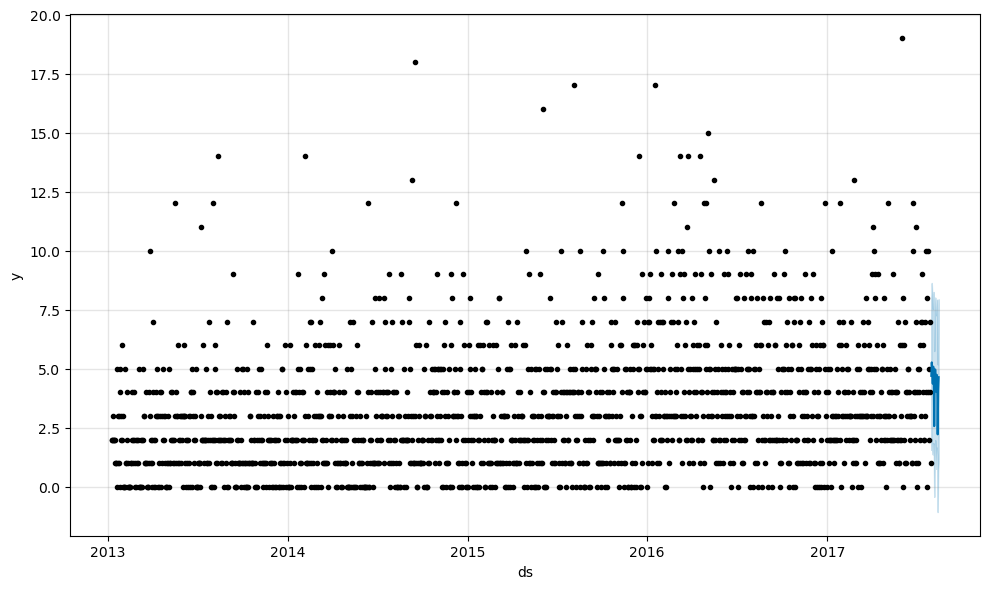

In [73]:
model_prophet.plot(y1_pred_fb)
plt.show()

In [74]:
# APE = ABS((actual - predicted) / actual)
APE_y1 = abs( (y1_test.values - y1_pred_fb['yhat'].values) / y1_test.values)

# MEAN(APE)
mAPE_y1 = np.mean(APE_y1)
print('MAPE: '+str(mAPE_y1))

MAPE: 0.7533845415421063
